In [3]:
from pprint import pformat as pf, pprint as pp
import json
import logging
import os

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

import requests
import pandas as pd
import numpy as np
import statsmodels

from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
import itermplot
%matplotlib inline

print(os.environ.get('MPLBACKEND', ''))
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

module://itermplot
0.10.1
1.17.2
0.25.1


In [4]:
url = 'http://192.168.0.156:8000/metrics?from=30'
response = requests.get(url)

In [5]:
#response.status_code = 404
if response.status_code == 200:
    print("web")
    data = json.loads(response.content.decode('utf-8'))
else:
    print("local")
    with open('sample.json', 'r') as f:
        data = json.load(f)


web


In [6]:
# Tidy Data
df = pd.DataFrame(data)
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df = df.set_index('ts')
del df['id']

In [7]:
df = df[df['metric'] == 'temperature'][['value']].resample('H').mean()
df = df.dropna()

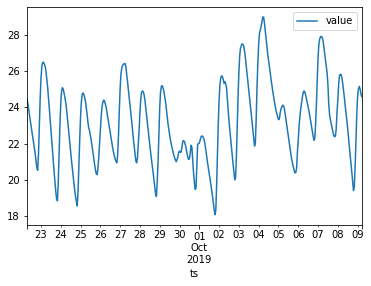

In [8]:
df.plot()

In [9]:
df_lag = df.shift()

In [10]:
df_diff = df - df_lag

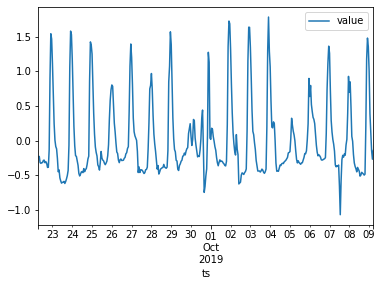

In [11]:
df_diff.plot()

In [12]:
df_acf = pd.DataFrame(stattools.acf(df.dropna(), fft=True))

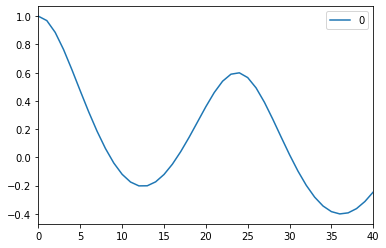

In [13]:
df_acf.plot()

In [14]:
df_pacf = pd.DataFrame(stattools.pacf(df.dropna(), method='ols-inefficient'))

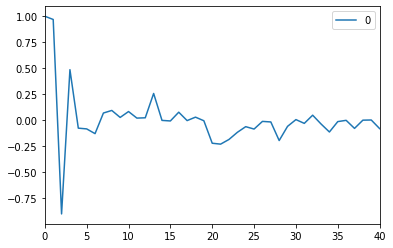

In [17]:
df_pacf.plot()